In [3]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Procesado y Modelado
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ==============================================================================================================================================================

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
# Configuración warnings
# ==============================================================================================================================================================

#Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [5]:
data1 = data.drop(["PBA", "VT1", "VT2", "DESTINO", "CAPACIDAD DEL CUARTO FRIO  "], axis=1)


In [6]:
data1["Franja1"] = data1["Franja1"].replace({"MADRUGADA": 1, "MAÑANA": 2, "MEDIO_DIA": 3, "TARDE": 4, "NOCHE": 5})
data1["Franja2"] = data1["Franja2"].replace({"MADRUGADA": 1, "MAÑANA": 2, "MEDIO_DIA": 3, "TARDE": 4, "NOCHE": 5})
data1["Refrigeracion"] = data1["Refrigeracion"].replace({"AMONIACO": 1, "GLICOL": 2})
data1["pH_Requisito"] = data1["pH_Requisito"].replace({"Mi_5.8": 1, "Mi_6": 2})
data1["Dia_Semana"] = data1["Dia_Semana"].replace({"lunes": 1, "martes": 2, "miércoles": 3, "jueves": 4, "viernes": 5, "sábado": 6})
data1["CF"] = data1["CF"].replace({"1PBA1": 1, "2PBA1": 2, "3PBA1": 3, "4PBA1": 4, "5PBA1": 5, "6PBA1": 6, "7PBA1": 7, "8PBA1": 8, "9PBA1": 9, "10PBA1": 10, "11PBA1": 11, "PBA2": 12})
data1["TIPO_CAP_CF"] = data1["TIPO_CAP_CF"].replace({"C1": 1, "C2": 2, "C3": 3, "PBA2": 4})

In [7]:
Conteo = data1.groupby('Rechazados').agg(cuantos=("Rechazados","count"))

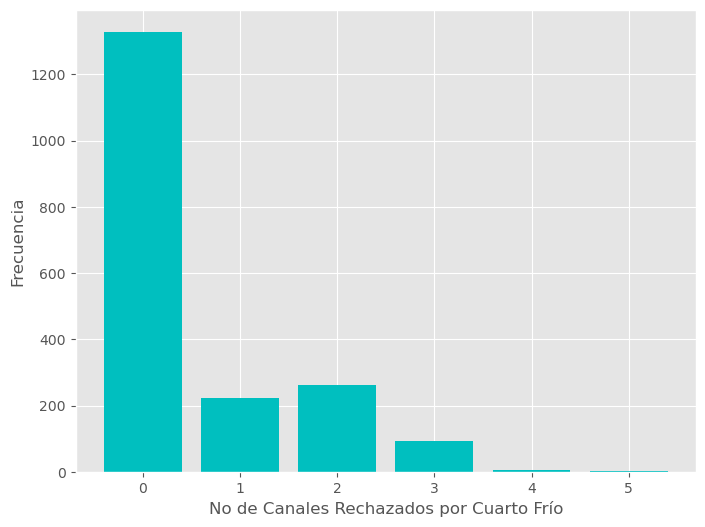

In [8]:
#data1.loc[data1["Rechazados"] > 2, "Rechazados"] = 3
Conteo = data1.groupby('Rechazados').agg(cuantos=("Rechazados","count"))

plt.figure(figsize=(8,6))
plt.bar(Conteo.index,Conteo["cuantos"],color="c")
plt.xlabel("No de Canales Rechazados por Cuarto Frío")
plt.ylabel("Frecuencia")
plt.show()


Gráficamente se adapta a una distribución Poisson con parámetro λ < 1


Lo anterior indica que hay una sobredispersión inclumpliendo la hipotesis de varianza = media

In [12]:
data1.isnull().sum() #Datos faltantes

Dia_Semana        0
Temp1             0
Franja1           0
Temp2             0
Franja2           0
Ti1               0
Temp3             0
Ti2               0
CF                0
Refrigeracion     0
Canales           0
PPPCF             0
Ocupacion         0
Indicador         0
pH_Requisito      0
Tamin            29
Taamax           29
TIPO_CAP_CF       0
Rechazados        0
dtype: int64

In [13]:
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


In [14]:
data0 = data1.copy()

In [15]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados"],axis=1), i) 
               for i in range(data1.drop(["Rechazados"],axis=1).shape[1])], 
              index=data1.drop(["Rechazados"],axis=1).columns)   

Dia_Semana         5.903262
Temp1              5.799112
Franja1           26.942187
Temp2             16.871067
Franja2           34.981340
Ti1                5.586215
Temp3              4.337079
Ti2                7.781030
CF                27.538732
Refrigeracion     54.326660
Canales          232.757280
PPPCF              8.692439
Ocupacion        277.725163
Indicador         15.875460
pH_Requisito      10.269060
Tamin            412.347168
Taamax           340.439991
TIPO_CAP_CF      130.551353
dtype: float64

In [16]:
data1 = data1.drop(["Tamin", "Franja1","Canales", "Ocupacion", "Temp2", "Taamax", "TIPO_CAP_CF", "Refrigeracion", "Franja2"], axis=1)

In [17]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados"],axis=1), i) 
               for i in range(data1.drop(["Rechazados"],axis=1).shape[1])], 
              index=data1.drop(["Rechazados"],axis=1).columns)   

Dia_Semana      5.664880
Temp1           4.468902
Ti1             4.233742
Temp3           3.594656
Ti2             6.811613
CF              5.285960
PPPCF           5.131455
Indicador       5.289338
pH_Requisito    9.303766
dtype: float64

In [18]:
expr = """Rechazados ~ Dia_Semana  + Temp1 + Ti1 + Temp3 + CF + Ti2 + PPPCF + Indicador + pH_Requisito"""

In [20]:
from patsy import dmatrices
y, X = dmatrices(expr, data1, return_type="dataframe")

# Modelo Poisson 

In [21]:
Poisson_Clasico = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(Poisson_Clasico.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Rechazados   No. Observations:                 1914
Model:                            GLM   Df Residuals:                     1904
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1975.1
Date:                Tue, 06 Jun 2023   Deviance:                       2517.4
Time:                        23:01:23   Pearson chi2:                 2.85e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08390
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8060      0.243      3.319   

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1234)

In [23]:
Poisson_Clasico_Train = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(Poisson_Clasico_Train.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Rechazados   No. Observations:                 1531
Model:                            GLM   Df Residuals:                     1521
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1607.4
Date:                Tue, 06 Jun 2023   Deviance:                       2042.9
Time:                        23:01:30   Pearson chi2:                 2.29e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08550
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9794      0.274      3.573   

In [24]:
predictions= Poisson_Clasico.predict(X_test)
#summary_frame() returns a pandas DataFrame
predictions.describe()

count    383.000000
mean       0.544175
std        0.235056
min        0.089957
25%        0.420622
50%        0.507348
75%        0.639357
max        2.277630
dtype: float64

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance
print("MSE", mean_squared_error(y_test,predictions))
print("MAE", mean_absolute_error(y_test,predictions))
print("mean Poisson deviance:", mean_poisson_deviance(y_test,predictions))


MSE 0.7234411593874792
MAE 0.6804887761775253
mean Poisson deviance: 1.2277943778723546


# Cumplimiento de supuesto



In [26]:
print("Relación Desviación de varianza sobre media:", predictions.var()/predictions.mean())

Relación Desviación de varianza sobre media: 0.10153203973666718


No se cumple el supuesto de varianza = media

## Probemos con la variable en frecuencia - Primero Rechazados sobre tiempo de maduración por cuarto frío en días

In [27]:
data2 = data1.copy()
data3 = data1.copy()
data2["Ti2"] = data2["Ti2"]/24
data2["Rechazados"] = data2["Rechazados"] / (data2["Ti2"])
data2 = data2.rename(columns={"Rechazados": "Rechazados_Frecuencia"})

In [28]:
expr2 = """Rechazados_Frecuencia ~ Dia_Semana  + Temp1 + Ti1 + Temp3 + CF + Ti2 + PPPCF + Indicador + pH_Requisito"""

In [29]:
y_i, X_i = dmatrices(expr2, data2, return_type="dataframe")
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_i, y_i, train_size=0.8, random_state=1234)


In [30]:
Poisson_Frecuencia1 = sm.GLM(y_train_F, X_train_F, alpha=0.1, sample_weigh = X_train_F["Ti2"], family=sm.families.Poisson()).fit()
print(Poisson_Frecuencia1.summary())


                   Generalized Linear Model Regression Results                   
Dep. Variable:     Rechazados_Frecuencia   No. Observations:                 1531
Model:                               GLM   Df Residuals:                     1521
Model Family:                    Poisson   Df Model:                            9
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -1303.8
Date:                   Tue, 06 Jun 2023   Deviance:                       1576.6
Time:                           23:02:46   Pearson chi2:                 1.83e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.05354
Covariance Type:               nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1

In [31]:
predictions_F = Poisson_Frecuencia1.predict(X_test_F)
print(predictions_F.describe())

count    383.000000
mean       0.416446
std        0.152448
min        0.045828
25%        0.317055
50%        0.406797
75%        0.510340
max        1.065342
dtype: float64


In [32]:
print("MSE", mean_squared_error(y_test_F,predictions_F))
print("MAE", mean_absolute_error(y_test_F,predictions_F))
print("mean Poisson deviance:", mean_poisson_deviance(y_test_F,predictions_F))


MSE 0.4701755117088528
MAE 0.531726733248668
mean Poisson deviance: 0.9892704403747102


In [33]:
print("Relación Desviación de varianza sobre media:", predictions_F.var()/predictions_F.mean())

Relación Desviación de varianza sobre media: 0.05580665646170805


No se cumple el supuesto de varianza = media

## Ahora Rechazados sobre tiempo de almacenamiento por cuarto frío en horas

In [34]:
data3["Rechazados"] = data3["Rechazados"] / (data3["Ti1"])
data3 = data3.rename(columns={"Rechazados": "Rechazados_Frecuencia"})

In [35]:
y_i2, X_i2 = dmatrices(expr2, data3, return_type="dataframe")
X_train_F2, X_test_F2, y_train_F2, y_test_F2 = train_test_split(X_i2, y_i2, train_size=0.8, random_state=1234)


In [36]:
Poisson_Frecuencia2 = sm.GLM(y_train_F2, X_train_F2, alpha=0.1, sample_weigh = X_train_F2["Ti1"], family=sm.families.Poisson()).fit()
print(Poisson_Frecuencia2.summary())


                   Generalized Linear Model Regression Results                   
Dep. Variable:     Rechazados_Frecuencia   No. Observations:                 1531
Model:                               GLM   Df Residuals:                     1521
Model Family:                    Poisson   Df Model:                            9
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -1057.1
Date:                   Tue, 06 Jun 2023   Deviance:                       1204.4
Time:                           23:03:37   Pearson chi2:                 1.45e+03
No. Iterations:                        6   Pseudo R-squ. (CS):             0.1015
Covariance Type:               nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1

In [37]:
predictions_F2 = Poisson_Frecuencia2.predict(X_test_F2)
print(predictions_F2.describe())

count    383.000000
mean       0.324018
std        0.220122
min        0.000069
25%        0.195329
50%        0.292859
75%        0.392507
max        1.706241
dtype: float64


In [38]:
print("MSE", mean_squared_error(y_test_F2,predictions_F2))
print("MAE", mean_absolute_error(y_test_F2,predictions_F2))
print("mean Poisson deviance:", mean_poisson_deviance(y_test_F2,predictions_F2))


MSE 0.25855532206217074
MAE 0.3901860064708212
mean Poisson deviance: 0.7046905918607042


In [39]:
print("Relación Desviación de varianza sobre media:", predictions_F2.var()/predictions_F2.mean())

Relación Desviación de varianza sobre media: 0.149540877397466


Como el Modelo Poisson no cumple el supuesto de media = a varianza priobaremos con el modelo de  regresión Binomial Negativa

# Modelo de regresión Binomial Negativa BN

Nuestro verdadero interés radica en el vector de tasas ajustadas λ 

In [40]:
print(Poisson_Clasico.mu)
print(len(Poisson_Clasico.mu))

[0.2060188  0.59135122 0.36407204 ... 0.92097496 0.54350278 0.21875757]
1914


Ahora ajustaremos el modelo de regresión OLS auxiliar en el conjunto de datos y usaremos el modelo ajustado para obtener el valor de α. Para ello Agregaremos el vector λ como una nueva columna llamada 'R_LAMBDA' 

In [41]:
import statsmodels.formula.api as smf

In [42]:
data1['R_LAMBDA'] = Poisson_Clasico.mu

A continuación, agreguemos una columna derivada llamada 'AUX_OLS_DEP'. Esta nueva columna almacenará los valores de la variable dependiente de la regresión OLS

In [43]:
data1['AUX_OLS_DEP'] = data1.apply(lambda x: ((x['Rechazados'] - x['R_LAMBDA'])**2 - x['R_LAMBDA']) / x['R_LAMBDA'], axis=1)

In [44]:
ols_expr = """AUX_OLS_DEP ~ R_LAMBDA - 1"""

In [45]:
aux_olsr_results = smf.ols(ols_expr, data1).fit()
print(aux_olsr_results.params)

R_LAMBDA    0.773104
dtype: float64


### ¿Es α estadísticamente significativo?

In [46]:
aux_olsr_results.tvalues

R_LAMBDA    6.992936
dtype: float64

A partir de encontrar el valor t , podemos ver que el valor t crítico con un nivel de confianza del 99 % (cola derecha) y grados de libertad=(1914 observaciones)  (1 parámetro de dispersión α) = 1913 es 2,328299. Esto es cómodamente menor que la estadística t de α que fue  6.992936. Concluimos que α= 0.773104 es estadísticamente significativo.

Ahora, Suministramos el valor de alfa encontrado  y encontramos  el modelo NB2 en el conjunto de datos de entrenamiento.statsmodels.genmod.families.family.NegativeBinomial

In [47]:
NB2 = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(NB2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Rechazados   No. Observations:                 1914
Model:                            GLM   Df Residuals:                     1904
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1882.2
Date:                Tue, 06 Jun 2023   Deviance:                       1795.7
Time:                        23:04:59   Pearson chi2:                 2.03e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06399
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8362      0.295      2.839   

In [49]:
NB2_TRAIN = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(NB2_TRAIN.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Rechazados   No. Observations:                 1531
Model:                            GLM   Df Residuals:                     1521
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1531.4
Date:                Tue, 06 Jun 2023   Deviance:                       1451.2
Time:                        23:05:41   Pearson chi2:                 1.62e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.06446
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0072      0.334      3.018   

In [51]:
predictionsNB = NB2_TRAIN.predict(X_test)
print(predictionsNB.describe())

count    383.000000
mean       0.560993
std        0.272166
min        0.067139
25%        0.417963
50%        0.511164
75%        0.654378
max        2.783560
dtype: float64


In [52]:
NB2_TRAIN.pearson_chi2

1618.2197868904077

Para hacer una determinación cuantitativa de la bondad de ajuste en algún nivel de confianza, digamos 95% (p=0.05), buscamos el valor en la tabla χ2 para p=0.05 y Grados de libertad de los residuos=1521. (Residuos DF = No. Observaciones menos modelo DF]). Comparamos este valor de chi-cuadrado con la estadística observada, en este caso, la desviación o el valor de chi-cuadrado de Pearson informado en GLMResults. Encontramos que en p=0.05 y DF Residuos = 1521, el valor de chi-cuadrado de una tabla estándar de Chi-cuadradoes 1652.24, que es por muy poco menor que la estadística informada de 1618.22 pero mayor que el valor de desviance = 1451. 

In [53]:
print("MSE", mean_squared_error(y_test,predictionsNB))
print("MAE", mean_absolute_error(y_test,predictionsNB))
print("mean Poisson deviance:", mean_poisson_deviance(y_test,predictionsNB))


MSE 0.7480918860495328
MAE 0.689460886476281
mean Poisson deviance: 1.251884865109223


El modelo no se ajusta por poco a los datos de entrenamientos

### Probemos La Variable de Respuesta en frecuencia - Caso 1 canales rechazados por cuarto frío  sobre el tiempo de maduración en días

In [54]:
len(Poisson_Frecuencia1.mu)

1531

In [55]:
X_train_F['R_LAMBDA2'] = Poisson_Frecuencia1.mu
X_train_F["Rechazados_Frecuencia"] = y_train_F
X_train_F['AUX_OLS_DEP2'] = X_train_F.apply(lambda x: ((x['Rechazados_Frecuencia'] - x['R_LAMBDA2'])**2 - x['R_LAMBDA2']) / x['R_LAMBDA2'], axis=1)
ols_expr2 = """AUX_OLS_DEP2 ~ R_LAMBDA2 - 1"""
aux_olsr_results2 = smf.ols(ols_expr2, X_train_F).fit()
print(aux_olsr_results2.params)

R_LAMBDA2    0.469946
dtype: float64


In [56]:
aux_olsr_results2.tvalues

R_LAMBDA2    3.22479
dtype: float64

A partir de encontrar el valor t , podemos ver que el valor t crítico con un nivel de confianza del 99 % (cola derecha) y grados de libertad=(1531 observaciones)  (1 parámetro de dispersión α) = 1530 es 2,328788. Esto es menor que la estadística t de α que fue  3.22479. Concluimos que α= 0.469946 es estadísticamente significativo.

In [57]:
NB2_TRAIN_F1 = sm.GLM(y_train_F, X_train_F.drop(["Rechazados_Frecuencia","R_LAMBDA2", "AUX_OLS_DEP2"],axis=1), family=sm.families.NegativeBinomial(alpha=aux_olsr_results2.params[0])).fit()
print(NB2_TRAIN_F1.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     Rechazados_Frecuencia   No. Observations:                 1531
Model:                               GLM   Df Residuals:                     1521
Model Family:           NegativeBinomial   Df Model:                            9
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -1287.8
Date:                   Tue, 06 Jun 2023   Deviance:                       1305.2
Time:                           23:07:31   Pearson chi2:                 1.53e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.04591
Covariance Type:               nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1

In [58]:
predictionsNB_F1 = NB2_TRAIN_F1.predict(X_test_F)
print(predictionsNB_F1.describe())


count    383.000000
mean       0.416761
std        0.155610
min        0.044162
25%        0.315408
50%        0.405455
75%        0.511940
max        1.071745
dtype: float64


In [59]:
print("MSE", mean_squared_error(y_test_F,predictionsNB_F1))
print("MAE", mean_absolute_error(y_test_F,predictionsNB_F1))
print("mean Poisson deviance:", mean_poisson_deviance(y_test_F,predictionsNB_F1))


MSE 0.47048587395630515
MAE 0.5315474000326236
mean Poisson deviance: 0.9892551204483352


In [60]:
print("Pearson chi2:", NB2_TRAIN_F1.pearson_chi2)
print("Pearson Deviance:", NB2_TRAIN_F1.deviance)

Pearson chi2: 1530.5467334317657
Pearson Deviance: 1305.2157860606949


Para hacer una determinación cuantitativa de la bondad de ajuste en algún nivel de confianza, digamos 95% (p=0.05), buscamos el valor en la tabla χ2 para p=0.05 y Grados de libertad de los residuos=1521. (Residuos DF = No. Observaciones menos modelo). Comparamos este valor de chi-cuadrado con la estadística observada, en este caso, la desviación o el valor de chi-cuadrado de Pearson informado en GLMResults. Encontramos que en p=0.05 y DF Residuos = 1521, el valor de chi-cuadrado de una tabla estándar de Chi-cuadradoes 1652.24, que está  encima de la estadística informada de 1530.54 y 1305.2 por lo tanto el modelo se ajusta muy bien a los datos de entrenamiento. 

### Caso 2 canales rechazados sobre el tiempo almacenamento en cada cuarto frío medido en horas

In [61]:
len(Poisson_Frecuencia2.mu)

1531

In [62]:
X_train_F2['R_LAMBDA3'] = Poisson_Frecuencia2.mu
X_train_F2["Rechazados_Frecuencia"] = y_train_F2
X_train_F2['AUX_OLS_DEP3'] = X_train_F2.apply(lambda x: ((x['Rechazados_Frecuencia'] - x['R_LAMBDA3'])**2 - x['R_LAMBDA3']) / x['R_LAMBDA3'], axis=1)
ols_expr3 = """AUX_OLS_DEP3 ~ R_LAMBDA3 - 1"""
aux_olsr_results3 = smf.ols(ols_expr3, X_train_F2).fit()
print(aux_olsr_results3.params)

R_LAMBDA3    0.571835
dtype: float64


In [63]:
aux_olsr_results3.tvalues

R_LAMBDA3    2.286237
dtype: float64

A partir de encontrar el valor t , podemos ver que el valor t crítico con un nivel de confianza del 99 % (cola derecha) y grados de libertad=(1531 observaciones)  (1 parámetro de dispersión α) = 1530 es 2,3. Este es migual que la estadística t de α que fue  2.3. Concluimos que α= 0.571835 es estadísticamente significativo.

In [64]:
NB2_TRAIN_F2 = sm.GLM(y_train_F2, X_train_F2.drop(["Rechazados_Frecuencia","R_LAMBDA3", "AUX_OLS_DEP3"],axis=1), family=sm.families.NegativeBinomial(alpha=aux_olsr_results3.params[0])).fit()
print(NB2_TRAIN_F2.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     Rechazados_Frecuencia   No. Observations:                 1531
Model:                               GLM   Df Residuals:                     1521
Model Family:           NegativeBinomial   Df Model:                            9
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -1057.6
Date:                   Tue, 06 Jun 2023   Deviance:                       979.63
Time:                           23:08:23   Pearson chi2:                 1.19e+03
No. Iterations:                        7   Pseudo R-squ. (CS):            0.08522
Covariance Type:               nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1

In [65]:
predictionsNB_F2 = NB2_TRAIN_F2.predict(X_test_F2)
print(predictionsNB_F2.describe())

count    383.000000
mean       0.323113
std        0.221674
min        0.000118
25%        0.189243
50%        0.292864
75%        0.386922
max        1.731632
dtype: float64


In [66]:
print("MSE", mean_squared_error(y_test_F2,predictionsNB_F2))
print("MAE", mean_absolute_error(y_test_F2,predictionsNB_F2))
print("mean Poisson deviance:", mean_poisson_deviance(y_test_F2,predictionsNB_F2))


MSE 0.2586258728888057
MAE 0.38835217676359707
mean Poisson deviance: 0.7017514167261705


In [67]:
print("Pearson chi:", NB2_TRAIN_F2.pearson_chi2)
print("Pearson Deviance:", NB2_TRAIN_F2.deviance)

Pearson chi: 1185.9192054561777
Pearson Deviance: 979.63438157224


Para hacer una determinación cuantitativa de la bondad de ajuste en algún nivel de confianza, digamos 95% (p=0.05), buscamos el valor en la tabla χ2 para p=0.05 y Grados de libertad de los residuos=1521. (Residuos DF = No. Observaciones menos modelo). Comparamos este valor de chi-cuadrado con la estadística observada, en este caso, la desviación o el valor de chi-cuadrado de Pearson informado en GLMResults. Encontramos que en p=0.05 y DF Residuos = 1521, el valor de chi-cuadrado de una tabla estándar de Chi-cuadradoes 1652.24, que está por encima de la estadística informada de 1185.92 y 979.63 por lo tanto el modelo se ajusta muy bien a los datos de entrenamiento. 

# Modelo de regresión de Poisson inflado a cero ZIP

In [68]:
X2 = data0[["Temp1", "Ti1", "Temp3", "Ti2", "Canales","PPPCF", "pH_Requisito", "Tamin"]] #"Dia_Semana",
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X2, y, train_size=0.8, random_state=1234)


In [69]:
zip__results = sm.ZeroInflatedPoisson(y_train_0, X_train_0, exog_infl=X_train_0, inflation='logit').fit()

         Current function value: 0.945619
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


In [70]:
print(zip__results.summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:              Rechazados   No. Observations:                 1531
Model:             ZeroInflatedPoisson   Df Residuals:                     1523
Method:                            MLE   Df Model:                            7
Date:                 Tue, 06 Jun 2023   Pseudo R-squ.:                 0.03539
Time:                         23:08:59   Log-Likelihood:                -1447.7
converged:                       False   LL-Null:                       -1500.9
Covariance Type:             nonrobust   LLR p-value:                 5.511e-20
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_Temp1           -0.0758      0.051     -1.481      0.139      -0.176       0.025
inflate_Ti1              0.0408      0.076      0.536      0.592      -0.109       0.190
infl

In [71]:
zip_predictions = zip__results.predict(X_test_0,exog_infl=X_test_0)
predicted_counts=np.round(zip_predictions)
actual_counts = y_test_0["Rechazados"]
print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2)))))


ZIP RMSE=16.97056274847714


In [72]:
zip_predictions 

1730    0.436889
1831    1.094511
362     0.338312
1402    0.606799
78      0.512618
          ...   
1792    0.498191
1614    0.541344
35      0.452762
956     0.102175
1577    1.011863
Length: 383, dtype: float64

In [73]:
print("MSE", mean_squared_error(y_test_0,zip_predictions))
print("MAE", mean_absolute_error(y_test_0,zip_predictions))
print("mean Poisson deviance:", mean_poisson_deviance(y_test_0,zip_predictions))

MSE 0.7110204815763748
MAE 0.6698978622961271
mean Poisson deviance: 1.21790117984598


### Inflado a Cero en terminos de frecuencias - Rechazados por cuarto frío / Tiempo de maduración en días

In [74]:
zip__results_F = sm.ZeroInflatedPoisson(y_train_F, X_train_F.drop(["R_LAMBDA2", "Rechazados_Frecuencia", "AUX_OLS_DEP2"],axis=1), exog_infl=X_train_F.drop(["R_LAMBDA2", "Rechazados_Frecuencia", "AUX_OLS_DEP2"],axis=1), inflation='logit').fit()

         Current function value: 0.801587
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


In [72]:
print(zip__results_F.summary())

                      ZeroInflatedPoisson Regression Results                     
Dep. Variable:     Rechazados_Frecuencia   No. Observations:                 1531
Model:               ZeroInflatedPoisson   Df Residuals:                     1521
Method:                              MLE   Df Model:                            9
Date:                   Thu, 18 May 2023   Pseudo R-squ.:                 0.07616
Time:                           21:01:09   Log-Likelihood:                -1227.2
converged:                         False   LL-Null:                       -1328.4
Covariance Type:               nonrobust   LLR p-value:                 1.062e-38
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_Intercept       -0.4824      0.978     -0.493      0.622      -2.399       1.434
inflate_Dia_Semana       0.2377      0.064      3.736      0.000       0.113 

In [75]:
zip_predictions_F = zip__results_F.predict(X_test_F,exog_infl=X_test_F)

In [76]:
print("MSE", mean_squared_error(y_test_F,zip_predictions_F))
print("MAE", mean_absolute_error(y_test_F,zip_predictions_F))
print("mean Poisson deviance:", mean_poisson_deviance(y_test_F,zip_predictions_F))

MSE 0.4663919377327615
MAE 0.5279891229581817
mean Poisson deviance: 0.9880629865141641


### Inflado a Cero - Rechazados por cuarto frío / Tiempo de almacenamiento en horas

In [77]:
zip__results_F2 = sm.ZeroInflatedPoisson(y_train_F2, X_train_F2.drop(["R_LAMBDA3", "Rechazados_Frecuencia", "AUX_OLS_DEP3"],axis=1), exog_infl=X_train_F2.drop(["R_LAMBDA3", "Rechazados_Frecuencia", "AUX_OLS_DEP3"],axis=1), inflation='logit').fit()

         Current function value: 0.667366
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


In [78]:
print(zip__results_F2.summary())

                      ZeroInflatedPoisson Regression Results                     
Dep. Variable:     Rechazados_Frecuencia   No. Observations:                 1531
Model:               ZeroInflatedPoisson   Df Residuals:                     1521
Method:                              MLE   Df Model:                            9
Date:                   Tue, 06 Jun 2023   Pseudo R-squ.:                  0.1030
Time:                           23:09:49   Log-Likelihood:                -1021.7
converged:                         False   LL-Null:                       -1139.0
Covariance Type:               nonrobust   LLR p-value:                 1.807e-45
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_Intercept        0.0219      2.001      0.011      0.991      -3.900       3.944
inflate_Dia_Semana      -0.0401      0.141     -0.285      0.776      -0.316 

In [79]:
zip_predictions_F2 = zip__results_F2.predict(X_test_F2,exog_infl=X_test_F2)

In [80]:
print("MSE", mean_squared_error(y_test_F2,zip_predictions_F2))
print("MAE", mean_absolute_error(y_test_F2,zip_predictions_F2))
print("mean Poisson deviance:", mean_poisson_deviance(y_test_F2,zip_predictions_F2))

MSE 0.2603952016880389
MAE 0.3838552382118695
mean Poisson deviance: 0.7116482031654401
